In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N=40
combined_df = pd.read_csv(f"calibrated_CI_ensemble_test_fewerhist_N{N}.csv")

meta_df = pd.read_csv("../uuss_data/p_resampled/uuss_test_fewerhist.csv")

In [3]:
widths = (combined_df.ub_y - combined_df.lb_y).values

30277
34407
15222


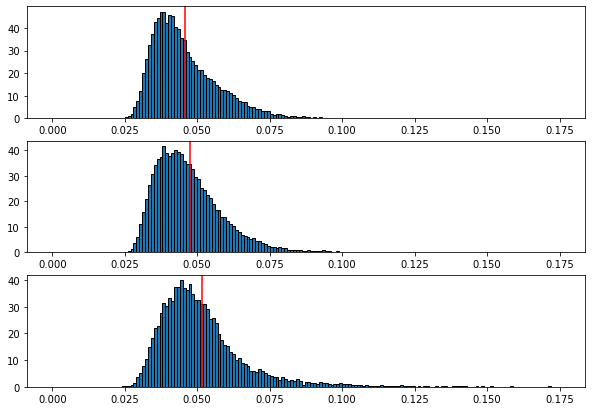

In [4]:
trimmed_std=combined_df["std"].values
one_inds = meta_df[meta_df["pick_quality"] == 1].index
print(len(one_inds))

two_inds = meta_df[meta_df["pick_quality"] == 0.75].index
print(len(two_inds))

three_inds = meta_df[meta_df["pick_quality"] == 0.5].index
print(len(three_inds))
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(trimmed_std[one_inds], density=True, bins=np.arange(0, 0.176, 0.001), edgecolor="k");
bins2 = axes[1].hist(trimmed_std[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(trimmed_std[three_inds], density=True, bins=bins[1], edgecolor="k");
axes[0].axvline(np.mean(trimmed_std[one_inds]), color="red");
axes[1].axvline(np.mean(trimmed_std[two_inds]), color="red");
axes[2].axvline(np.mean(trimmed_std[three_inds]), color="red");

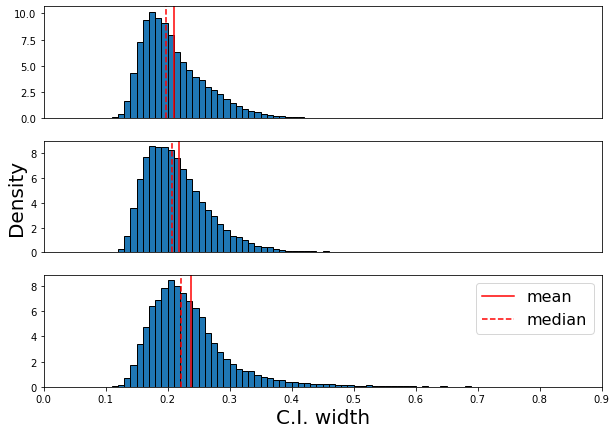

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(widths[one_inds], density=True, bins=np.arange(0, 0.9, 0.01), edgecolor="k");
bins2 = axes[1].hist(widths[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(widths[three_inds], density=True, bins=bins[1], edgecolor="k");

axes[0].axvline(np.mean(widths[one_inds]), color="red");
axes[1].axvline(np.mean(widths[two_inds]), color="red");
axes[2].axvline(np.mean(widths[three_inds]), color="red", label="mean");

axes[0].axvline(np.median(widths[one_inds]), color="red", linestyle="--");
axes[1].axvline(np.median(widths[two_inds]), color="red", linestyle="--");
axes[2].axvline(np.median(widths[three_inds]), color="red", linestyle="--", label="median");

axes[2].set_xlabel("C.I. width", fontsize=20)
axes[1].set_ylabel("Density", fontsize=20)
axes[2].legend(fontsize=16)
for ax in range(3):
    axes[ax].set_xlim([0, 0.9])
    
axes[0].set_xticks([]);
axes[1].set_xticks([]);

In [6]:
np.sum(widths < 0.1)

0

In [7]:
((combined_df["y_act"] > combined_df["lb_y"]) & (combined_df["y_act"] < combined_df["ub_y"])).sum()/len(combined_df)

0.8892198333041323

In [8]:
((combined_df["y_act"] > (combined_df["y_pred"])-combined_df["std"]) & (combined_df["y_act"] < (combined_df["y_pred"])+combined_df["std"])).sum()/len(combined_df)

0.6866067629464621

# SNR

In [9]:
snr_values = np.loadtxt("../uuss_data/P_test_fewerhist_snrs.txt")

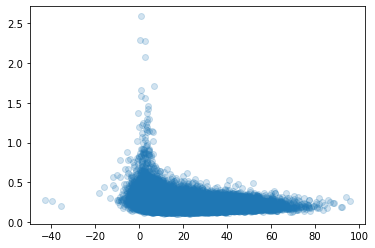

In [10]:
plt.scatter(snr_values, widths, alpha=0.2)

(0.0, 1.8)

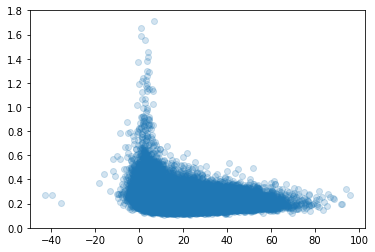

In [11]:
plt.scatter(snr_values, widths, alpha=0.2)
plt.ylim([0, 1.80])

In [12]:
# #snr_values_clipped
# snr_values[np.where(snr_values > 37)] = 37
# snr_values

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
data = pd.DataFrame({"snr":snr_values, "width":widths})
mod = smf.quantreg("width ~ snr + I(snr ** 2.0)", data)
#mod = smf.quantreg("width ~ snr", data)

res = mod.fit(q=0.5)
print(res.summary())

quantiles = [0.05, 0.5, 0.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["snr"]] + res.conf_int().loc[
        "snr"].tolist()


models = [mod.fit(q=x) for x in quantiles]
#models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])


                         QuantReg Regression Results                          
Dep. Variable:                  width   Pseudo R-squared:              0.03388
Model:                       QuantReg   Bandwidth:                    0.005553
Method:                 Least Squares   Sparsity:                       0.1189
Date:                Fri, 23 Dec 2022   No. Observations:                79906
Time:                        16:10:51   Df Residuals:                    79903
                                        Df Model:                            2
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2419      0.001    422.703      0.000       0.241       0.243
snr              -0.0032   5.19e-05    -60.777      0.000      -0.003      -0.003
I(snr ** 2.0)  4.855e-05   1.01e-06     48.276      0.000    4.66e-05    5.05e-05

The condition number is large, 2.11e

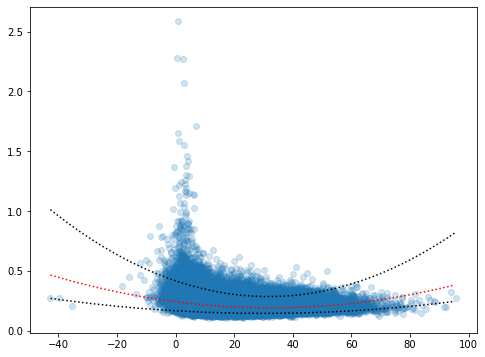

In [15]:
x = np.arange(data.snr.min(), data.snr.max(), 1)
get_y = lambda a, b: a + b * x
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(snr_values, widths, alpha=0.2)
ax.plot(x, models[0].predict({'snr':x}), linestyle="dotted", color="k")
ax.plot(x, models[-1].predict({'snr':x}), linestyle="dotted", color="k")
ax.plot(x, models[1].predict({'snr':x}), linestyle="dotted", color="red")

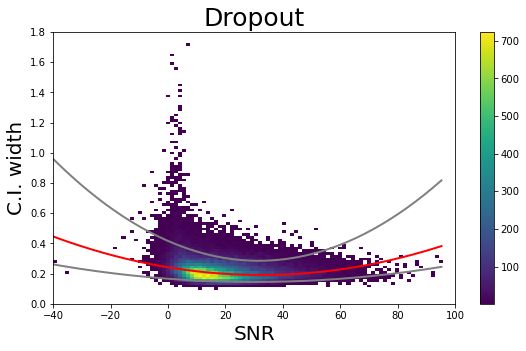

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[-40, 100], [0, 1.8]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

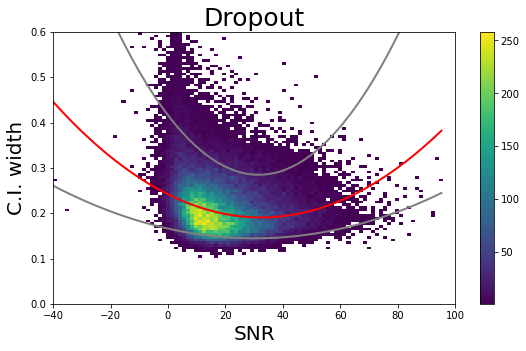

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[-40, 100], [0, 0.6]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

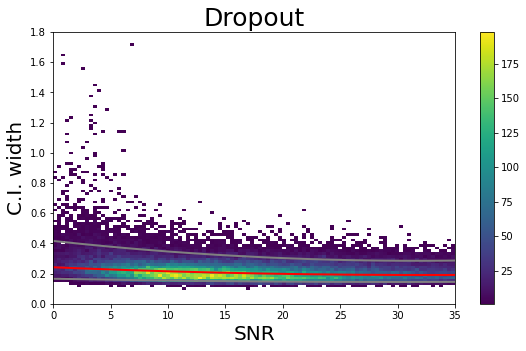

In [18]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[0, 35], [0, 1.8]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

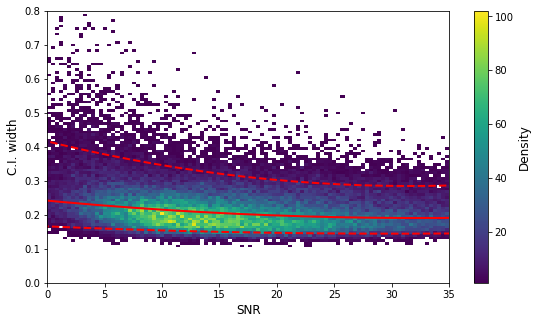

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, 
              range=[[0, 35], [0, 0.8]], vmin=1, vmax=102);
ax.set_ylabel("C.I. width", fontsize=12)
ax.set_xlabel("SNR", fontsize=12)
#ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

cb = plt.colorbar(h[-1], ax=ax)
cb.set_label(label='Density', fontsize=12)

In [20]:
np.nanmax(h[0])

102.0

In [23]:
data = pd.DataFrame({"snr":snr_values, "std":combined_df["std"].values})

mod = smf.quantreg("std ~ snr + I(snr ** 2.0)", data)
#mod = smf.quantreg("width ~ snr", data)

res = mod.fit(q=0.5)
print(res.summary())

quantiles = [0.05, 0.5, 0.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["snr"]] + res.conf_int().loc[
        "snr"].tolist()


models = [mod.fit(q=x) for x in quantiles]

                         QuantReg Regression Results                          
Dep. Variable:                    std   Pseudo R-squared:              0.03388
Model:                       QuantReg   Bandwidth:                    0.001208
Method:                 Least Squares   Sparsity:                      0.02588
Date:                Fri, 23 Dec 2022   No. Observations:                79906
Time:                        16:14:27   Df Residuals:                    79903
                                        Df Model:                            2
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0526      0.000    422.633      0.000       0.052       0.053
snr              -0.0007   1.13e-05    -60.755      0.000      -0.001      -0.001
I(snr ** 2.0)  1.056e-05   2.19e-07     48.257      0.000    1.01e-05     1.1e-05

The condition number is large, 2.11e

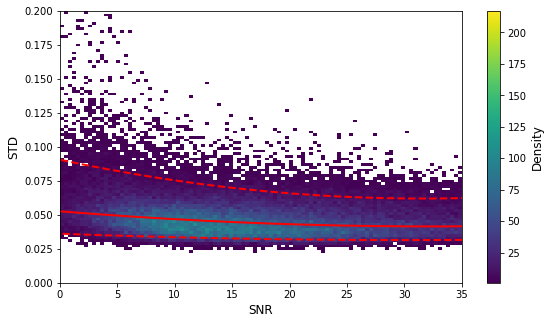

In [27]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, combined_df["std"], bins=((100, 100)), cmap=plt.cm.viridis, cmin=1,
              range=[[0, 35], [0, 0.2]], vmin=1, vmax=217);
ax.set_ylabel("STD", fontsize=12)
ax.set_xlabel("SNR", fontsize=12)
#ax.set_title("Dropout", fontsize=25)
ax.plot(x, models[0].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

cb = plt.colorbar(h[-1], ax=ax)
cb.set_label(label='Density', fontsize=12)

In [25]:
np.nanmax(h[0])

109.0